# Classification Workbook

Goal: Predict a good night's sleep (defined by getting 7+ hours of sleep in a night) using FitBit activity data. 

## Data Preparation

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from IPython.display import SVG
from graphviz import Source
from sklearn import tree

# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import LearningCurveDisplay
# from sklearn.svm import SVC
# from sklearn.svm import LinearSVR
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_excel("hourlyActivity_merged.xlsx")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22458 entries, 0 to 22457
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ActivityHour  22458 non-null  datetime64[ns]
 1   Id            22458 non-null  int64         
 2   StepTotal     22458 non-null  int64         
 3   Calories      22458 non-null  int64         
 4   0=sedentary   22458 non-null  int64         
 5   1=light       22458 non-null  int64         
 6   2=moderate    22458 non-null  int64         
 7   3=veryactive  22458 non-null  int64         
 8   1=asleep      22458 non-null  int64         
 9   2=restless    22458 non-null  int64         
 10  3=awake       22458 non-null  int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 1.9 MB


In [5]:
# define Total Sleep Time as the amount of time a person spends trying to sleep

df["Total Sleep Time"] = df["1=asleep"]+df["2=restless"]+df["3=awake"]

In [6]:
# extract date & time separately from Date/Time field

df["ActivityDate"] = pd.to_datetime(df["ActivityHour"]).dt.date
df["ActivityTime"] = pd.to_datetime(df["ActivityHour"]).dt.time

df.head()

,ActivityHour,Id,StepTotal,Calories,0=sedentary,1=light,2=moderate,3=veryactive,1=asleep,2=restless,3=awake,Total Sleep Time,ActivityDate,ActivityTime
0,2016-04-11 20:00:00,2026352035,0,0,0,0,0,0,11,1,0,12,2016-04-11,20:00:00
1,2016-04-11 21:00:00,1927972279,0,0,0,0,0,0,4,0,0,4,2016-04-11,21:00:00
2,2016-04-11 21:00:00,2026352035,0,0,0,0,0,0,44,15,1,60,2016-04-11,21:00:00
3,2016-04-11 21:00:00,4020332650,0,0,0,0,0,0,36,4,3,43,2016-04-11,21:00:00
4,2016-04-11 22:00:00,1927972279,0,0,0,0,0,0,60,0,0,60,2016-04-11,22:00:00


In [7]:
# remove participants who didn't reliably sleep with their FitBit on
# Defined as: 4hrs * 60 mins * 30 days = 7200 mins slept minimum to be counted as "regularly sleeping with FitBit"

df.loc[:,["ActivityDate","Id","1=asleep","2=restless","3=awake","Total Sleep Time"]].groupby(["Id"]).sum().describe()

,1=asleep,2=restless,3=awake,Total Sleep Time
count,33.000000,33.000000,33.000000,33.000000
mean,5226.666667,424.939394,61.151515,5712.757576
std,5476.410678,816.211942,72.655489,5928.601427
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,2085.000000,154.000000,39.000000,2883.000000
75%,10789.000000,573.000000,90.000000,11671.000000
max,14368.000000,4577.000000,303.000000,15682.000000


In [8]:
# keep 14/33 participants with that threshold
df_2 = df.loc[:,["ActivityDate","ActivityTime","Id","1=asleep","2=restless","3=awake","Total Sleep Time"]].groupby(["Id"]).sum()
df_2[df_2["Total Sleep Time"]>7200].describe()

,1=asleep,2=restless,3=awake,Total Sleep Time
count,14.000000,14.000000,14.000000,14.000000
mean,11082.642857,909.000000,100.928571,12092.571429
std,2469.226151,1081.936725,48.366333,2501.593822
min,6702.000000,273.000000,39.000000,7370.000000
25%,9064.750000,482.000000,70.000000,10099.000000
50%,11053.500000,592.500000,88.000000,12175.500000
75%,13478.250000,770.750000,127.250000,14100.250000
max,14368.000000,4577.000000,195.000000,15682.000000


In [9]:
sleep_IDs = df_2.index.values
#sleep_IDs

In [10]:
df_sleep = df[df["Id"].isin(sleep_IDs)]
#df_sleep.head(50)

In [11]:
# Look at distribution of sleep times
df_sleep.loc[:,["ActivityTime","Total Sleep Time"]].groupby(["ActivityTime"]).sum()

,Total Sleep Time
ActivityTime,
00:00:00,16792
01:00:00,18820
02:00:00,21129
03:00:00,22680
04:00:00,22129
05:00:00,20256
06:00:00,15289
07:00:00,9672
08:00:00,5945


In [12]:
# define day from 08:00 to 07:00. 
# e.g. Monday starts at 08:00 on Monday and goes until 07:00 on Tuesday
# Hour 00:00 to 07:00 need to shift back one day
# Hour 08:00 to 23:00 stay the same day

df_sleep["ActivityDateShifted"] = df_sleep["ActivityDate"] - datetime.timedelta(days=1)

In [13]:
for i in range(len(df_sleep.index)):
    if df_sleep.iloc[i,13] <= datetime.time(7,0,0):  # 13th col: Time
        df_sleep.iloc[i, 12] = df_sleep.iloc[i, 14]   # 12th col: Date; shift back


df_sleep.drop("ActivityDateShifted", axis=1, inplace=True)
df_sleep.head(50)

,ActivityHour,Id,StepTotal,Calories,0=sedentary,1=light,2=moderate,3=veryactive,1=asleep,2=restless,3=awake,Total Sleep Time,ActivityDate,ActivityTime
0,2016-04-11 20:00:00,2026352035,0,0,0,0,0,0,11,1,0,12,2016-04-11,20:00:00
1,2016-04-11 21:00:00,1927972279,0,0,0,0,0,0,4,0,0,4,2016-04-11,21:00:00
2,2016-04-11 21:00:00,2026352035,0,0,0,0,0,0,44,15,1,60,2016-04-11,21:00:00
3,2016-04-11 21:00:00,4020332650,0,0,0,0,0,0,36,4,3,43,2016-04-11,21:00:00
4,2016-04-11 22:00:00,1927972279,0,0,0,0,0,0,60,0,0,60,2016-04-11,22:00:00
5,2016-04-11 22:00:00,2026352035,0,0,0,0,0,0,47,13,0,60,2016-04-11,22:00:00
6,2016-04-11 22:00:00,4020332650,0,0,0,0,0,0,57,2,1,60,2016-04-11,22:00:00
7,2016-04-11 22:00:00,5553957443,0,0,0,0,0,0,40,0,0,40,2016-04-11,22:00:00
8,2016-04-11 22:00:00,5577150313,0,0,0,0,0,0,19,0,0,19,2016-04-11,22:00:00
9,2016-04-11 22:00:00,7086361926,0,0,0,0,0,0,44,5,0,49,2016-04-11,22:00:00


In [14]:
# group data by date

df_daily_sleep = df_sleep.groupby(["ActivityDate","Id"]).sum()
df_daily_sleep.head()

StepTotal  Calories  0=sedentary  1=light  \
ActivityDate Id                                                      
2016-04-11   1503960366        684       439            0        0   
             1624580081         38       407            0        0   
             1644430081         53       680            0        0   
             1844505072          0       448            0        0   
             1927972279         24       686            0        0   

                         2=moderate  3=veryactive  1=asleep  2=restless  \
ActivityDate Id                                                           
2016-04-11   1503960366           0             0       294          13   
             1624580081           0             0         0           0   
             1644430081           0             0         0           0   
             1844505072           0             0         0           0   
             1927972279           0             0       570          16   

                         3=awake  Total Sleep Time  
ActivityDate Id                                     
2016-04-11   1503960366        6               313  
             1624580081        0                 0  
             1644430081        0                 0  
             1844505072        0                 0  
             1927972279        0               586

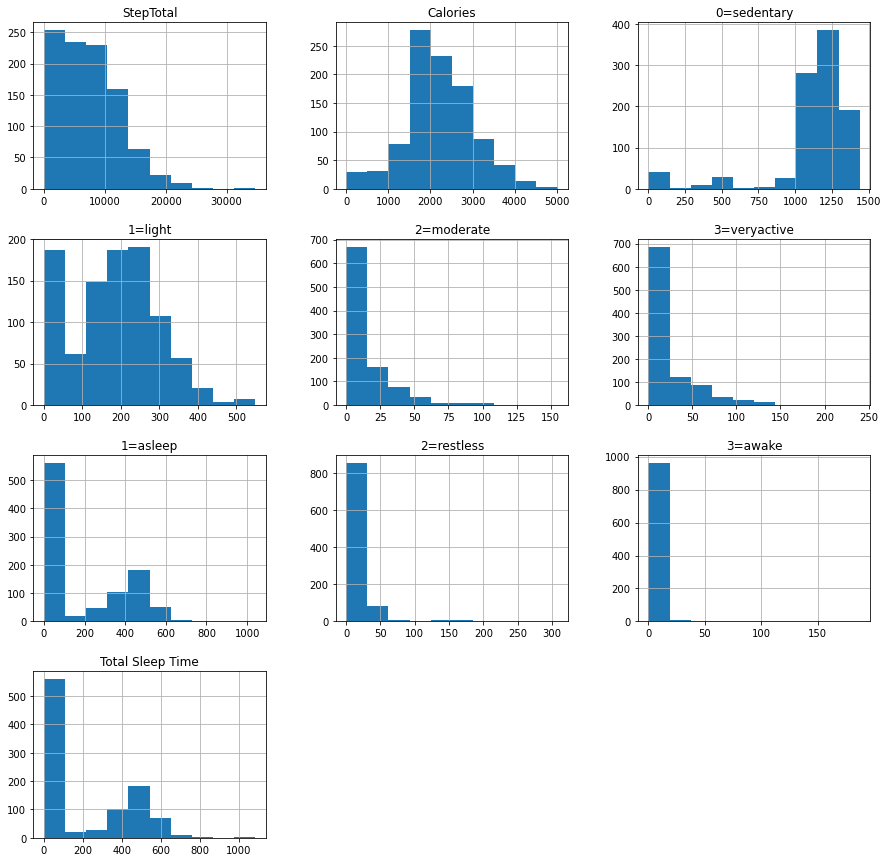

In [15]:
# the histograms show a lot of Total Sleep Time values clustered around zero

df_daily_sleep.hist(figsize=(15,15))
plt.show()

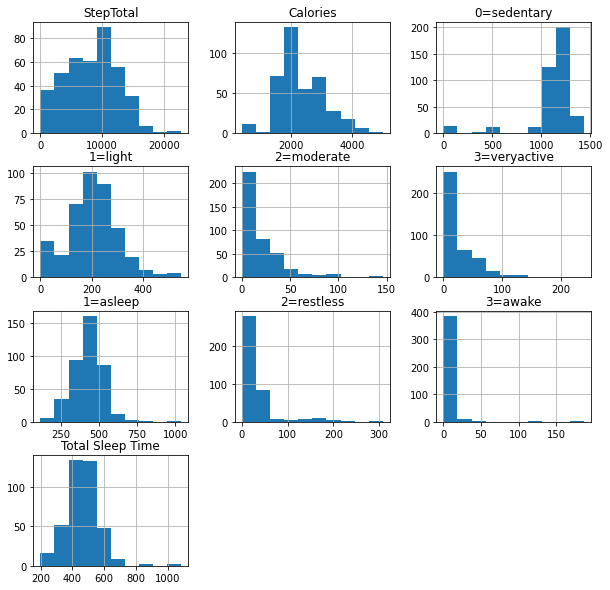

In [16]:
# of the people who regularly track sleep data, remove any nights of sleep with less than 3 recorded hours of sleep (180 mins)

df_daily_sleep[df_daily_sleep["Total Sleep Time"]>=180].hist(figsize=(10,10))
plt.show()

In [17]:
df_clean = df_daily_sleep[df_daily_sleep["Total Sleep Time"]>=180]

df_clean.describe()

,StepTotal,Calories,0=sedentary,1=light,2=moderate,3=veryactive,1=asleep,2=restless,3=awake,Total Sleep Time
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,8310.275253,2331.868687,1113.133838,203.338384,18.674242,24.967172,427.209596,34.686869,4.994949,466.891414
std,4238.461779,767.471428,260.475271,97.904974,23.275726,36.250206,99.196437,42.296398,12.282744,104.632429
min,0.000000,377.000000,0.000000,0.000000,0.000000,0.000000,114.000000,0.000000,0.000000,199.000000
25%,5172.250000,1817.000000,1109.750000,151.000000,1.000000,1.000000,368.000000,15.000000,1.000000,406.750000
50%,8669.500000,2176.500000,1169.000000,201.500000,11.000000,8.000000,435.000000,23.000000,3.000000,463.500000
75%,11332.000000,2875.000000,1219.000000,257.000000,28.000000,38.000000,488.500000,35.250000,6.000000,525.250000
max,22753.000000,5014.000000,1440.000000,549.000000,146.000000,240.000000,1040.000000,308.000000,187.000000,1086.000000


## EDA (Daily Sleep Data)

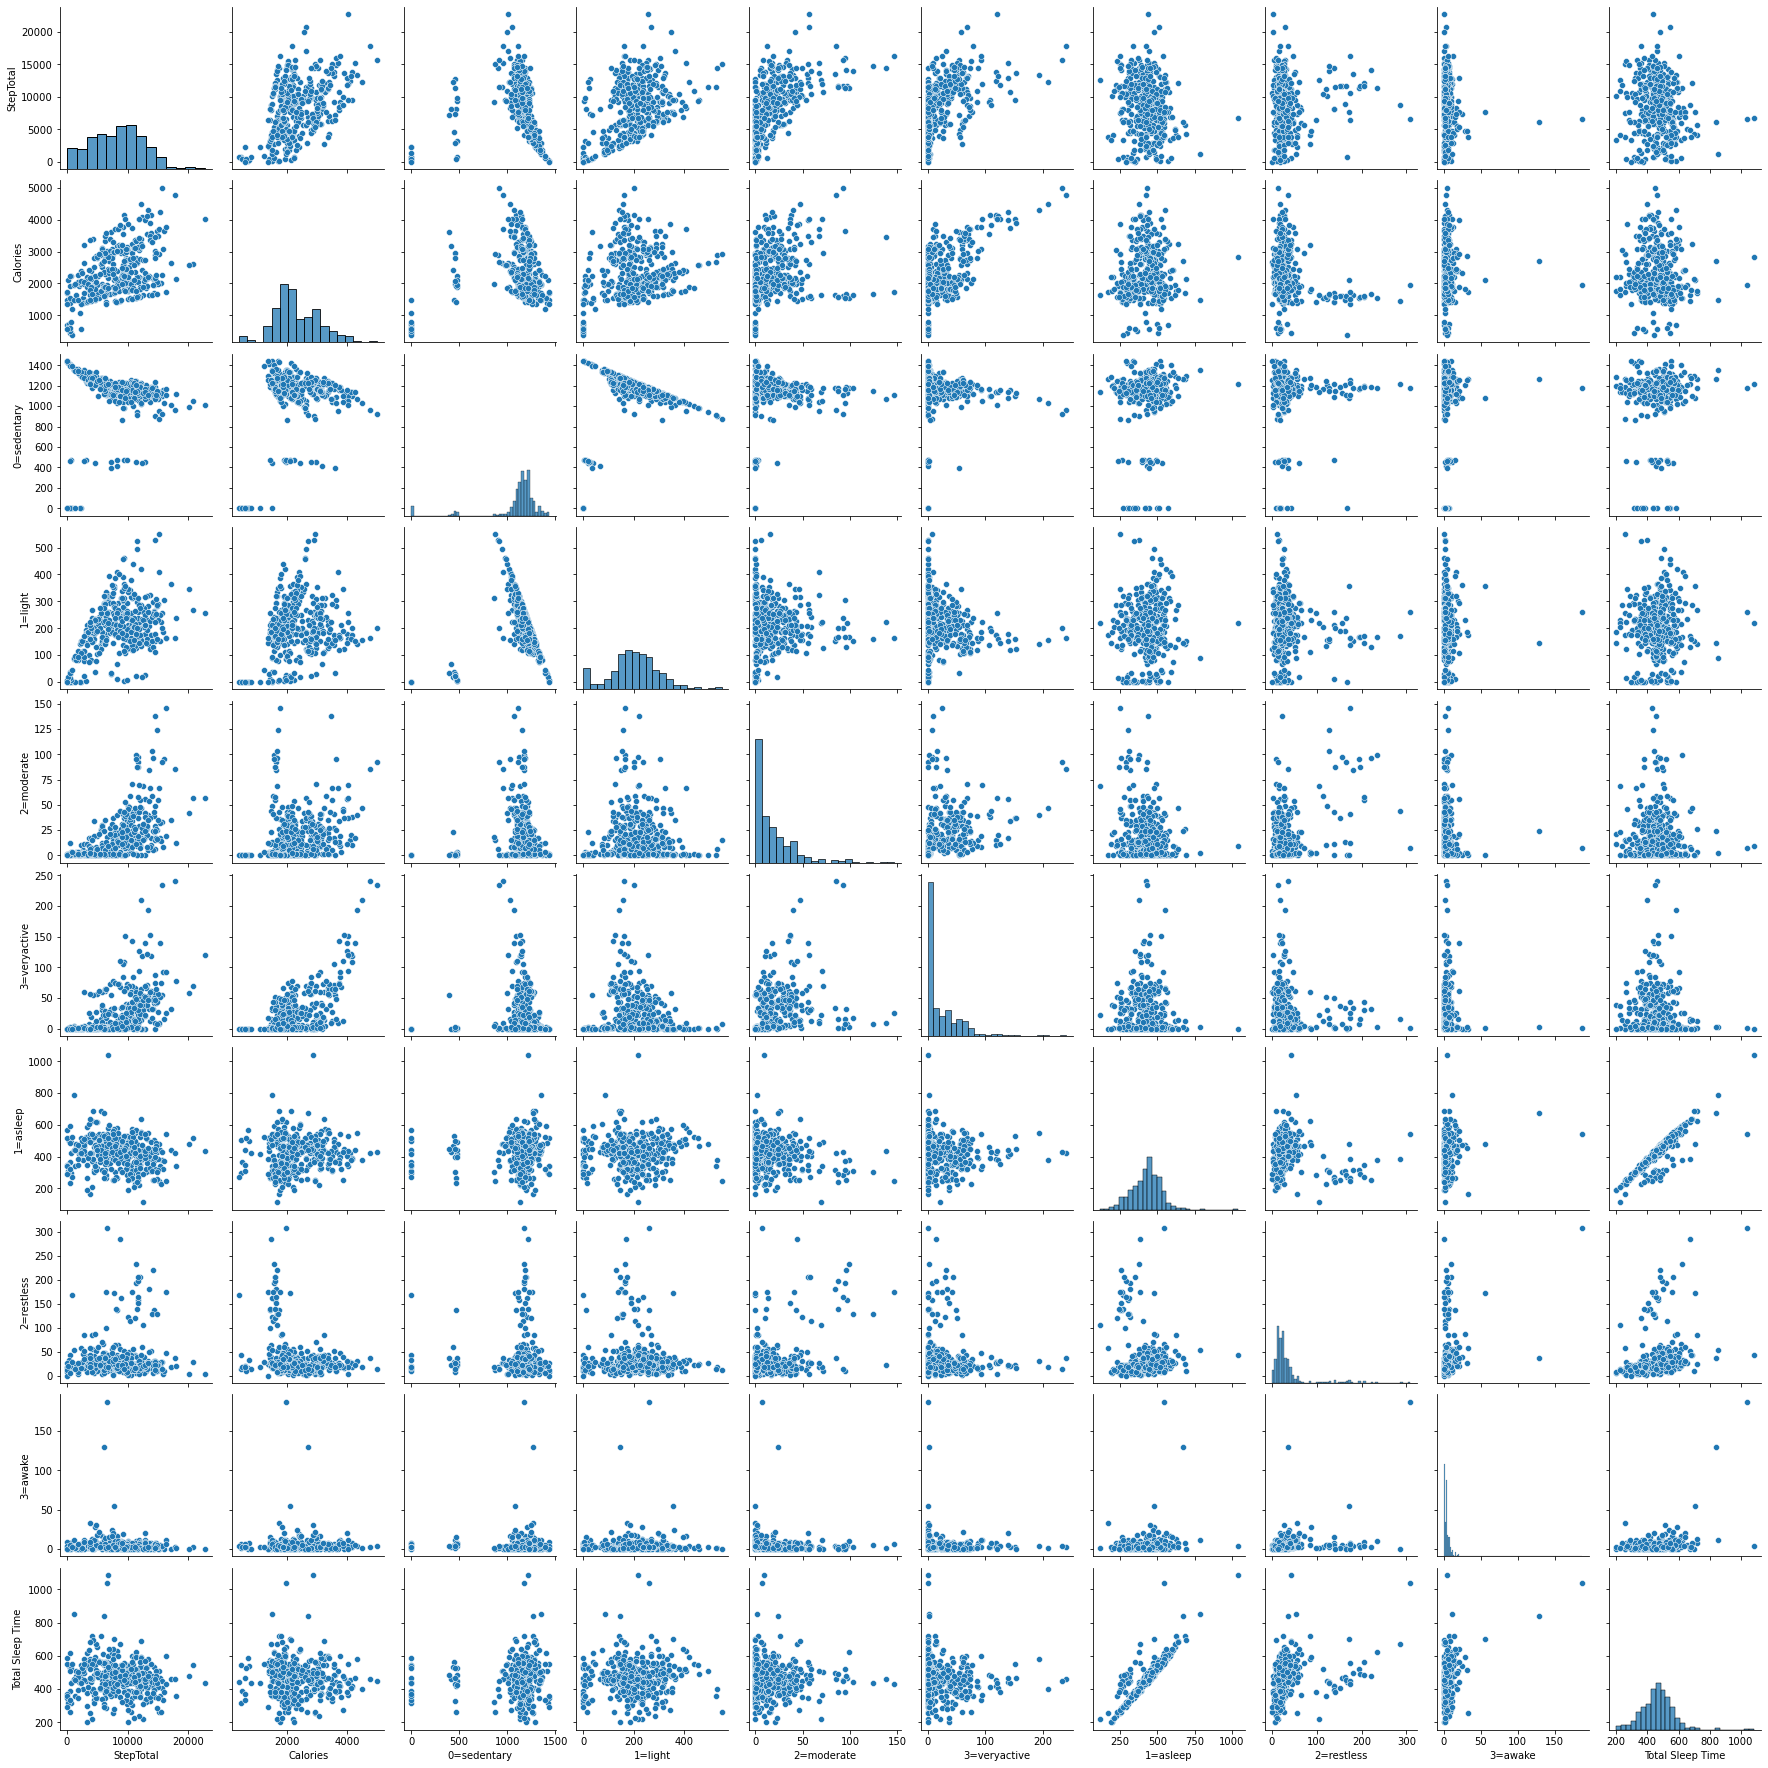

In [18]:
sns.pairplot(df_clean)

In [19]:
df_clean.corr()

,StepTotal,Calories,0=sedentary,1=light,2=moderate,3=veryactive,1=asleep,2=restless,3=awake,Total Sleep Time
StepTotal,1.000000,0.430905,0.069843,0.450934,0.583118,0.529121,-0.180791,0.092660,-0.074200,-0.142652
Calories,0.430905,1.000000,0.226616,0.191866,0.227081,0.609858,0.041822,-0.271622,0.004350,-0.069640
0=sedentary,0.069843,0.226616,1.000000,0.252489,0.086898,0.072811,0.073811,0.016542,0.029808,0.080163
1=light,0.450934,0.191866,0.252489,1.000000,0.041576,-0.105165,0.042715,-0.063170,0.017667,0.017034
2=moderate,0.583118,0.227081,0.086898,0.041576,1.000000,0.351375,-0.221898,0.378815,-0.063109,-0.064647
3=veryactive,0.529121,0.609858,0.072811,-0.105165,0.351375,1.000000,-0.086957,-0.074667,-0.067986,-0.120604
1=asleep,-0.180791,0.041822,0.073811,0.042715,-0.221898,-0.086957,1.000000,-0.180816,0.139798,0.891365
2=restless,0.092660,-0.271622,0.016542,-0.063170,0.378815,-0.074667,-0.180816,1.000000,0.331835,0.271769
3=awake,-0.074200,0.004350,0.029808,0.017667,-0.063109,-0.067986,0.139798,0.331835,1.000000,0.384064
Total Sleep Time,-0.142652,-0.069640,0.080163,0.017034,-0.064647,-0.120604,0.891365,0.271769,0.384064,1.000000


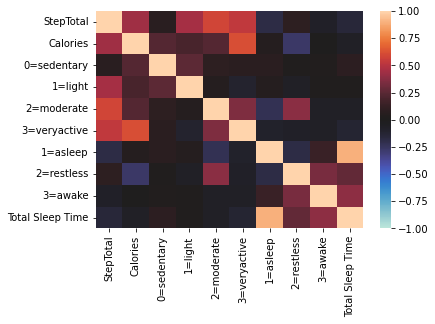

In [20]:
sns.heatmap(df_clean.corr(), vmin=-1, vmax=1, center=0);

## Classification Model

In [23]:
# Define boolean field "Good Sleep" as sleeping 7+ hours per night

df_clean['Good Sleep'] = (df_clean['1=asleep']>420)
df_clean['Good Sleep'].sum()

C:\Users\Julia\AppData\Local\Temp\ipykernel_10780\761747470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Good Sleep'] = (df_clean['1=asleep']>420)


233

In [24]:
# define dependent/independent variables

X=df_clean.loc[:,['StepTotal','Calories','0=sedentary','1=light','2=moderate','3=veryactive']]
y=df_clean.loc[:,'Good Sleep']

In [25]:
# Apply MinMax Scaler

num_scl_step = ('scl', MinMaxScaler())
num_steps = [num_scl_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, X.columns)]

ct = ColumnTransformer(transformers=num_transformers)
ct.fit(df_clean)
X = ct.transform(X)

In [26]:
# train/test split, stratified by class

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [27]:
# naive classifier results in an F1 score of 0.83 and accuracy of 0.7 for both train & test

print("Train F1:", (y_train==1).sum()/((y_train==1).sum()+0.5*((y_train==0).sum())))
print("Test F1:", (y_test==1).sum()/((y_test==1).sum()+0.5*((y_test==0).sum())))

print("Train accuracy:", (y_train==1).sum()/((y_train==1).sum()+(y_train==0).sum()))
print("Test accuracy: ", (y_test==1).sum()/((y_test==1).sum()+(y_test==0).sum()))

Train F1: 0.7415254237288136
Test F1: 0.7388535031847133
Train accuracy: 0.5892255892255892
Test accuracy:  0.5858585858585859


### Logistic Regression

In [28]:
logi = LogisticRegression(max_iter=10000)

In [30]:
param_dict = {"penalty": ["l2",'none'], "C":np.linspace(0,2,21)}

logi_search = RandomizedSearchCV(logi, param_dict, random_state=4)
search = logi_search.fit(X_train,y_train)
search.best_params_

C:\Users\Julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

{'penalty': 'l2', 'C': 1.4000000000000001}

In [48]:
logi_opt = LogisticRegression(penalty='l2',C=0.4,max_iter=10000)
logi_opt.fit(X_train, y_train);
print("Logistic Regression Opt F1 Score: ", f1_score(y_test, logi_opt.predict(X_test)))
print("Logistic Regression Opt Accuracy Score: ", accuracy_score(y_test, logi_opt.predict(X_test)))

Logistic Regression Opt F1 Score:  0.7236842105263159
Logistic Regression Opt Accuracy Score:  0.5757575757575758


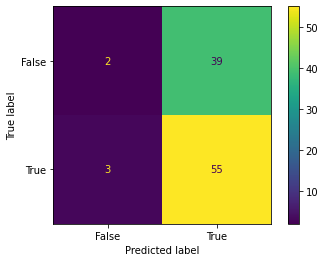

In [49]:
cm = confusion_matrix(y_test, logi_opt.predict(X_test), labels=logi_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logi_opt.classes_)
disp.plot()
plt.show()

### RFC

In [33]:
rfc = RandomForestClassifier(max_depth=5, random_state=0)

In [35]:
param_dict = {"n_estimators": range(10,100,10), "criterion":['gini','entropy','log_loss'], "max_depth":range(1,8), 
              "bootstrap":[True,False]}

rfc_search = RandomizedSearchCV(rfc, param_dict, random_state=4)
search = rfc_search.fit(X_train,y_train)
search.best_params_

C:\Users\Julia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Julia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Julia\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Julia\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Julia\anaconda3\lib\site-packages\jo

{'n_estimators': 30, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}

In [50]:
rfc_opt = RandomForestClassifier(n_estimators = 30, max_depth=5, criterion='gini',bootstrap=False, random_state=0)
rfc_opt.fit(X_train, np.ravel(y_train));

print("Random Forest Opt F1 Score: ", f1_score(y_test, rfc_opt.predict(X_test)))
print("Random Forest Opt Accuracy Score: ", accuracy_score(y_test, rfc_opt.predict(X_test)))

Random Forest Opt F1 Score:  0.7681159420289855
Random Forest Opt Accuracy Score:  0.6767676767676768


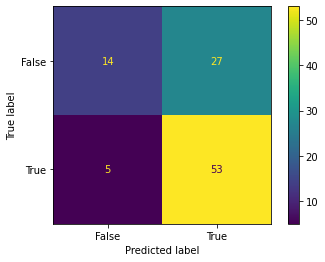

In [51]:
cm = confusion_matrix(y_test, rfc_opt.predict(X_test), labels=rfc_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rfc_opt.classes_)
disp.plot()
plt.show()

### Gradient Boosting

In [38]:
gbt = GradientBoostingClassifier()

In [40]:
param_dict = {"loss":['log_loss','exponential'], "n_estimators": range(50,400,50), "subsample":np.linspace(0.1,1,10), 
             "criterion":['friedman_mse', 'squared_error'], "max_depth":range(1,10)}

gbt_search = RandomizedSearchCV(gbt, param_dict, random_state=4)
search = gbt_search.fit(X_train,y_train)
search.best_params_

C:\Users\Julia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Julia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Julia\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\Julia\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss

{'subsample': 0.30000000000000004,
 'n_estimators': 200,
 'max_depth': 7,
 'loss': 'exponential',
 'criterion': 'friedman_mse'}

In [41]:
gbt_opt = GradientBoostingClassifier(loss='exponential', n_estimators=200, subsample=0.3, criterion='friedman_mse', max_depth=7)
gbt_opt.fit(X_train, np.ravel(y_train));

print("GBT Opt F1 Score: ", f1_score(y_test, gbt_opt.predict(X_test)))
print("GBT Opt Accuracy Score: ", accuracy_score(y_test, gbt_opt.predict(X_test)))

GBT Opt F1 Score:  0.736
GBT Opt Accuracy Score:  0.6666666666666666


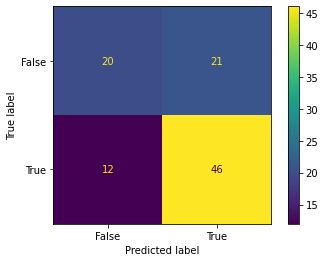

In [42]:
cm = confusion_matrix(y_test, gbt_opt.predict(X_test), labels=gbt_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = gbt_opt.classes_)
disp.plot()
plt.show()

### AdaBoost

In [43]:
ada = AdaBoostClassifier()
ada.fit(X_train, np.ravel(y_train));

print("AdaBoost F1 Score: ", f1_score(y_test, ada.predict(X_test)))
print("AdaBoost Accuracy Score: ", accuracy_score(y_test, ada.predict(X_test)))

AdaBoost F1 Score:  0.7154471544715447
AdaBoost Accuracy Score:  0.6464646464646465


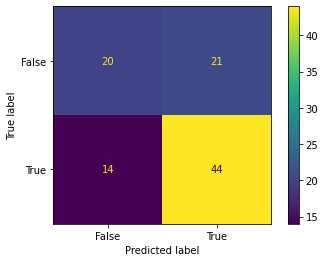

In [44]:
cm = confusion_matrix(y_test, ada.predict(X_test), labels=ada.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ada.classes_)
disp.plot()
plt.show()

### Extra Trees Classifier

In [45]:
etc = ExtraTreesClassifier()
etc.fit(X_train, np.ravel(y_train));

print("ETC F1 Score: ", f1_score(y_test, etc.predict(X_test)))
print("ETC Accuracy Score: ", accuracy_score(y_test, etc.predict(X_test)))

ETC F1 Score:  0.765625
ETC Accuracy Score:  0.696969696969697


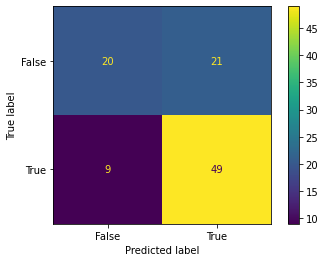

In [46]:
cm = confusion_matrix(y_test, etc.predict(X_test), labels=etc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = etc.classes_)
disp.plot()
plt.show()

## Look into best model: RFC

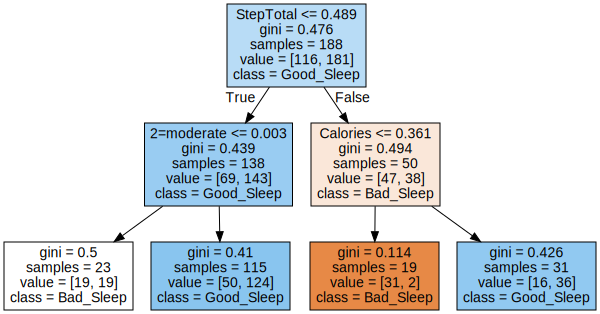

In [47]:
#visualizing one tree of the random forest

graph = Source(tree.export_graphviz(rfc_opt.estimators_[4], out_file=None,
                                    feature_names=['StepTotal','Calories','0=sedentary','1=light','2=moderate','3=veryactive'],
                                    class_names=["Bad_Sleep","Good_Sleep"], 
                                    filled = True
                                   ))
display(SVG(graph.pipe(format='svg')))

Doesn't look like you can really meaningfully predict whether someone is going to have a good night's sleep based purely on their activity level. Missing many other meaningful data points like their emotional state, eating/drinking habits, working schedule, family status, etc. 